# The Battle of the Neighborhoods - New York City

*In This Project We are going to use data science methodology, modelling and analysis tools to find the best neighborhood in NYC with maximum venues nearby in order to access these venues very easily and in minimum time*

*Also, we will use the Foursquare API to explore neighborhoods in New York City. We will use the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the k-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.*

#### Before we get the data and start exploring it, let's download all the dependencies that we will need

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    cer

## 1. Extract Data of NYC Neighborhoods from the Link

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.
We use the link below for the data set: 
https://geo.nyu.edu/catalog/nyu_2451_34572

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

how all the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transform the data into a pandas dataframe

Then the neighborhood_data list is passed to pandas to create a DataFrame

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [8]:
neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The map shows that the neighborhoods codes are not evenly spaced, and the area cover by some of them, using a radius of 500 meters, overlaps. A different radius for each neighborhood results in a better venues search because that will avoid misrepresentation of the number of venues per neighborhood caused by too large or low radius values.

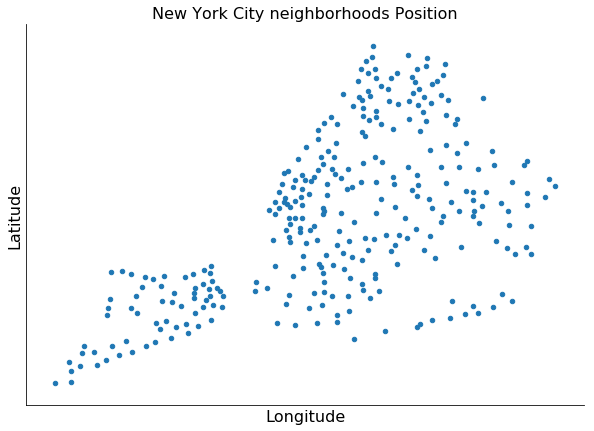

In [13]:
import matplotlib.pyplot as plt

X = neighborhoods[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(10, 7))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('New York City neighborhoods Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

To define the radius use with foursquare it's necessary to find the closest points for each neighborhood.

In [14]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_neighborhood(neighborhood, neighborhoodds):
    neighborhood = np.asarray(neighborhood).reshape(1,-1)
    neighborhoodds = np.asarray(neighborhoodds)
    distances = [great_circle(neighborhood, point).meters for point in neighborhoodds]
    closest_neighborhood_index = np.argmin(distances)
    return [round(distances[closest_neighborhood_index]), closest_neighborhood_index]

To explore the distance function, the closest neighborhood to the first example in the dataframe is found

In [15]:
coordinates = neighborhoods[['Latitude', 'Longitude']]

distance, closest_point_index = closest_neighborhood(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-73.847201,40.894705
45,-73.848083,40.884561


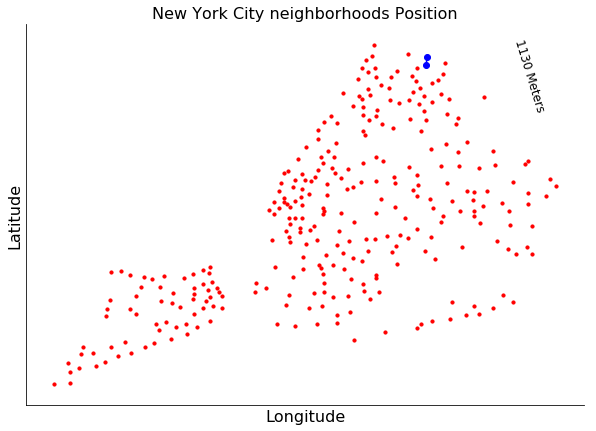

In [16]:
fig = plt.figure(figsize=(10,7))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('New York City neighborhoods Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

A distant column is added to the DataFrame and is used as the radius cover for each neighborhood.

In [17]:
from math import isnan

for lat, lng, idx in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods.index):
    distance, closest_point_index = closest_neighborhood([lat,lng], coordinates[~coordinates.index.isin([idx])])
    neighborhoods.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude,Distance
0,Bronx,Wakefield,40.894705,-73.847201,565.0
1,Bronx,Co-op City,40.874294,-73.829939,481.0
2,Bronx,Eastchester,40.887556,-73.827806,742.0
3,Bronx,Fieldston,40.895437,-73.905643,388.0
4,Bronx,Riverdale,40.890834,-73.912585,388.0
5,Bronx,Kingsbridge,40.881687,-73.902818,436.0
6,Manhattan,Marble Hill,40.876551,-73.910660,384.0
7,Bronx,Woodlawn,40.898273,-73.867315,868.0
8,Bronx,Norwood,40.877224,-73.879391,468.0
9,Bronx,Williamsbridge,40.881039,-73.857446,439.0


The map is plotted using different radius for each neighborhood code. Now not only overlapping was avoided but more area of the city is cover, consequently, more venues are retrieved.

In [18]:
map = folium.Map(location=[40.7127281, -74.0060152], zoom_start=11)

for location in neighborhoods.itertuples(): #iterate each row of the dataframe
    label = 'Borough: {};  Neighborhoods: {}'.format(location[1], location[2])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

## 2. Get Venues from Foursquare 

In order to get the venues in the perimeter of each neighborhood, it is necessary to get the geographical coordinates (lat and lng) of each one of those and add them to the dataframe. 

In [53]:
CLIENT_ID = 'Insert Client ID' # your Foursquare ID
CLIENT_SECRET = 'Insert Client Secret' # your Foursquare Secret
VERSION = '20181102'

To explore the data returned by the Foursquare API, a maximum of 100 venues from the first neighborhood are requested in a radius of 500 meters.

In [20]:
#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [54]:
first_neighborhood = neighborhoods.iloc[2, :]
url = format_url(first_neighborhood['Latitude'], first_neighborhood['Longitude'], first_neighborhood['Distance'])
#url

Send the GET request and examine the resutls.

In [23]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dd204476001fe001bd4e4d0'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Eastchester',
  'headerFullLocation': 'Eastchester, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 35,
  'suggestedBounds': {'ne': {'lat': 40.894233684028784,
    'lng': -73.81898954721193},
   'sw': {'lat': 40.88087767067277, 'lng': -73.83662334711632}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '515cc20ce4b0deb133b8e89b',
       'name': 'Fish & Ting',
       'location': {'address': '4063 Boston Rd',
        'lat': 40.88553926848355,
        'lng': -73.82915130799964,
        'labeledLatLngs': [{'lab

In [24]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [25]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Fish & Ting,Caribbean Restaurant,40.885539,-73.829151
1,Cozy Cottage Restaurant,Diner,40.886332,-73.827616
2,Mario's Pizza,Pizza Place,40.888628,-73.831260
3,Dyre Fish Market,Seafood Restaurant,40.889318,-73.831453
4,Taco Bell,Fast Food Restaurant,40.883029,-73.824901
5,Dyre Deli Grocery,Deli / Bodega,40.888235,-73.831282
6,HomeGoods,Furniture / Home Store,40.890814,-73.820849
7,Smashburger,Burger Joint,40.890172,-73.820584
8,St. Paul's Church National Historic Site,Historic Site,40.893482,-73.825328
9,Dunkin',Donut Shop,40.885384,-73.828099


And how many venues were returned by Foursquare?

In [26]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

35 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in NYC

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called NY_venues.

In [28]:
NY_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### Let's check the size of the resulting dataframe

In [29]:
print(NY_venues.shape)
NY_venues.head(10)

(10277, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
5,Wakefield,40.894705,-73.847201,SUBWAY,40.890656,-73.849192,Sandwich Place
6,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
7,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,Laundromat
8,Co-op City,40.874294,-73.829939,Dollar Tree,40.870125,-73.828989,Discount Store
9,Co-op City,40.874294,-73.829939,Rite Aid,40.870345,-73.828302,Pharmacy


In [30]:
print('New York City Neighborhoods:', neighborhoods['Neighborhood'].shape[0])
print('New York City Neighborhoods with Venues:', NY_venues['Neighborhood'].unique().shape[0])

New York City Neighborhoods: 306
New York City Neighborhoods with Venues: 301


There is 5 neighborhood with no venues returned from the Foursquare API

In [31]:
neighborhoods_diff = np.setdiff1d(neighborhoods['Neighborhood'].values,NY_venues['Neighborhood'].unique())
neighborhoods[neighborhoods['Neighborhood']==neighborhoods_diff[0]]

,Borough,Neighborhood,Latitude,Longitude,Distance
257,Staten Island,Howland Hook,40.638433,-74.186223,493.0


## 3. Analyze venues data

In order to get a better sense of the best way of clustering the neighborhoods, it's necessary to analyze the venues data returned by Foursquare.

In [32]:
venues_in_neighborhoods = NY_venues.groupby('Neighborhood').count()
venues_in_neighborhoods = pd.DataFrame(list(zip(venues_in_neighborhoods.index, venues_in_neighborhoods['Venue'])), 
                                  columns=['Neighborhood', 'No. of Venues']).set_index('Neighborhood').join(neighborhoods[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
venues_in_neighborhoods['Distance'] = np.int64(venues_in_neighborhoods['Distance'])
venues_in_neighborhoods.loc[len(venues_in_neighborhoods.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_neighborhoods.head(10)

,Neighborhood,No. of Venues,Distance
0,Allerton,32,353
1,Annadale,12,643
2,Arden Heights,4,694
3,Arlington,5,470
4,Arrochar,19,417
5,Arverne,18,515
6,Astoria,100,697
7,Astoria Heights,13,447
8,Auburndale,17,774
9,Bath Beach,46,656


In [33]:
venues_in_neighborhoods[['No. of Venues']].describe()

,No. of Venues
count,306.000000
mean,34.725490
std,32.207877
min,0.000000
25%,12.000000
50%,22.000000
75%,46.000000
max,146.000000


The minimum amount of venues present on a neighborhood is 0, and the maximum is 146, expected given the limit of venues set on the request sent to the Foursquare API. 50% of the venues presents 22 or less venues.

The venues Frequency Distribution of the number of venues is presented next.

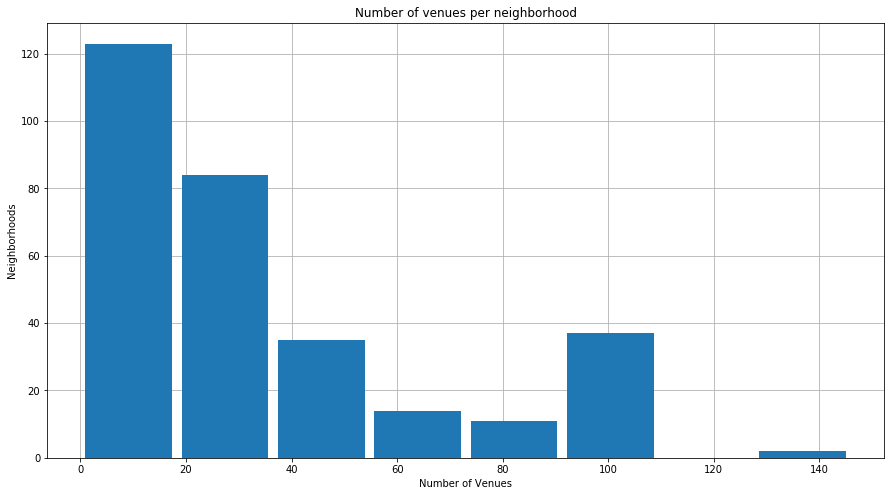

In [34]:
venues_in_neighborhoods['No. of Venues'].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Neighborhoods')
plt.title('Number of venues per neighborhood')
plt.show()

Given that each neighborhood has a different radius passed to the venues request, it's better to represent the venues per neighborhood in terms of density, that's venues per are cover for each neighborhood, in this case the area cover in the venues search defined by the distance to the closest neighborhood.

In [35]:
density_venues_in_neighborhood = NY_venues.groupby('Neighborhood').count()

density_venues_in_neighborhood = pd.DataFrame(list(zip(density_venues_in_neighborhood.index, density_venues_in_neighborhood['Venue'])), 
                                  columns=['Neighborhood', 'Density']).set_index('Neighborhood').join(neighborhoods[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
density_venues_in_neighborhood['Density'] = np.int64(density_venues_in_neighborhood['Density']/(density_venues_in_neighborhood['Distance']/1000)) #distance in km
density_venues_in_neighborhood.loc[len(venues_in_neighborhoods.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_neighborhood.head(10)

,Neighborhood,Density,Distance
0,Allerton,90,353.0
1,Annadale,18,643.0
2,Arden Heights,5,694.0
3,Arlington,10,470.0
4,Arrochar,45,417.0
5,Arverne,34,515.0
6,Astoria,143,697.0
7,Astoria Heights,29,447.0
8,Auburndale,21,774.0
9,Bath Beach,70,656.0


In [36]:
density_venues_in_neighborhood[['Density']].describe()

,Density
count,306.000000
mean,81.098039
std,97.312932
min,0.000000
25%,21.000000
50%,43.500000
75%,90.000000
max,485.000000


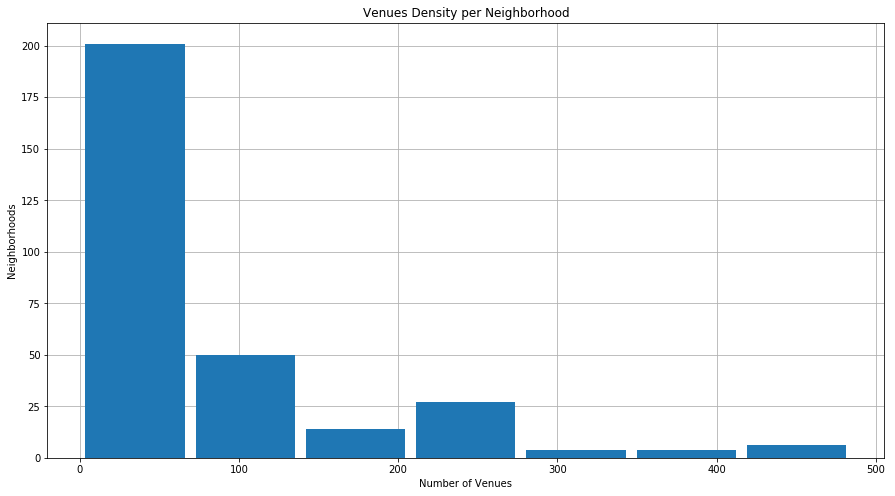

In [37]:
density_venues_in_neighborhood['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Neighborhoods')
plt.title('Venues Density per Neighborhood')
plt.show()

The diagram above shows that 50% of the neighborhoods presents a density between 0 and 45 venues per area (expressed as radius). That is expected given that NYC has a high population density. The last three bars on the plot have very low values.

## 4. Cluster Neighborhoods in NYC

Next the neighborhoods are clustered based on venues density. One important hyperparameter is the number of clusters and based on previous analysis a tentative value is five clusters. Next the elbow method is used to have a better sense of the optimal number.

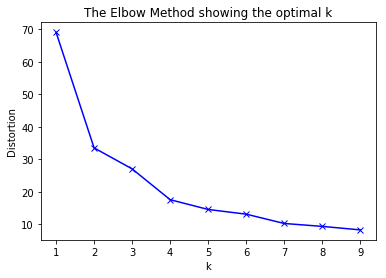

In [38]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_neighborhood['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_neighborhood['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_neighborhood['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Using the elbow method, the optimal value of the number of cluster was defined as 7, which match with the value based on the histogram analysis.

In [39]:
print(density_venues_in_neighborhood.shape)

(306, 3)


In [40]:
num_clusters = 7

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_neighborhood['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[4 0 0 0 3 3 6 3 0 4 5 6 3 4 4 4 0 4 3 0 0 4 0 5 3 0 4 0 5 3 0 0 3 0 3 3 1
 0 0 4 4 0 0 0 1 5 0 0 4 3 1 1 2 0 4 1 3 0 4 2 5 3 1 3 3 4 4 0 3 0 3 4 5 3
 4 5 5 0 0 0 4 3 3 5 4 0 0 0 3 0 0 4 4 0 3 3 0 5 3 1 3 0 4 1 4 3 1 6 0 0 1
 4 3 3 0 1 1 0 3 3 3 3 6 0 2 0 6 3 3 4 3 3 0 0 4 4 2 0 4 0 4 1 6 0 4 3 6 0
 6 4 0 4 1 0 6 0 2 1 6 0 6 0 0 0 3 4 4 0 4 0 0 3 4 0 0 5 1 0 4 0 4 3 3 4 4
 6 3 2 1 0 3 3 0 3 4 5 3 3 2 4 0 0 4 3 3 3 3 0 0 6 4 4 4 4 3 0 0 3 0 0 6 4
 5 0 0 3 0 3 4 4 3 4 0 0 3 0 0 4 3 4 6 3 3 0 3 0 3 0 3 4 0 2 0 0 0 0 0 2 3
 0 0 4 4 0 3 3 1 6 1 3 1 3 0 4 0 3 1 5 5 3 4 1 6 3 3 4 0 6 3 4 3 1 4 0 0 0
 1 0 3 3 3 3 3 6 1 0]


In [41]:
density_venues_in_neighborhood['Cluster'] = k_means.labels_
density_venues_in_neighborhood.head(10)

,Neighborhood,Density,Distance,Cluster
0,Allerton,90,353.0,4
1,Annadale,18,643.0,0
2,Arden Heights,5,694.0,0
3,Arlington,10,470.0,0
4,Arrochar,45,417.0,3
5,Arverne,34,515.0,3
6,Astoria,143,697.0,6
7,Astoria Heights,29,447.0,3
8,Auburndale,21,774.0,0
9,Bath Beach,70,656.0,4


## 5. Examine Clusters

Check the centroids values of venues density and neighborhoods per cluster

In [42]:
centroids = np.int64(round(density_venues_in_neighborhood.groupby('Cluster').mean()['Density']))
frecuency = density_venues_in_neighborhood.groupby('Cluster').count()['Neighborhood']

cluster_info = pd.DataFrame([np.arange(0,7), centroids, frecuency], index=['Cluster', 'Centroid','Neighborhoods']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Neighborhoods
0,0,14,98
1,3,38,79
2,4,74,61
3,6,129,19
4,1,213,25
5,5,278,15
6,2,442,9


### 'Very Low Venues Density': Centroid equal to 14
### 'Low Venues Density': Centroid equal to 38
### 'Medium-Low Venues Density' with a centroid equal to 74
### 'Medium Venues Density' with a centroid equal to 129
### 'Medium-High Venues Density' with a centroid equal to 213
### 'High Venues Density' with a centr0id equal to 278
### 'Very High Venues Density' with a centroid equal to 442

In [43]:
# 'Very Low Venues Density': Centroid equal to 13
# 'Low Venues Density': Centroid equal to 39
# 'Medium-Low Venues Density' with a centroid equal to 75
# 'Medium Venues Density' with a centroid equal to 134
# 'Medium-High Venues Density' with a centroid equal to 218
# 'High Venues Density' with a centr0id equal to 279
# 'Very High Venues Density' with a centroid equal to 442
raw_data = {'Cluster': ['Very Low Venues Density','Low Venues Density','Medium-Low Venues Density','Medium Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density'],
        'Neighborhood': [92, 89, 58, 20, 24, 14, 9]}
df = pd.DataFrame(raw_data, columns = ['Cluster', 'Neighborhood'])
df

,Cluster,Neighborhood
0,Very Low Venues Density,92
1,Low Venues Density,89
2,Medium-Low Venues Density,58
3,Medium Venues Density,20
4,Medium-High Venues Density,24
5,High Venues Density,14
6,Very High Venues Density,9


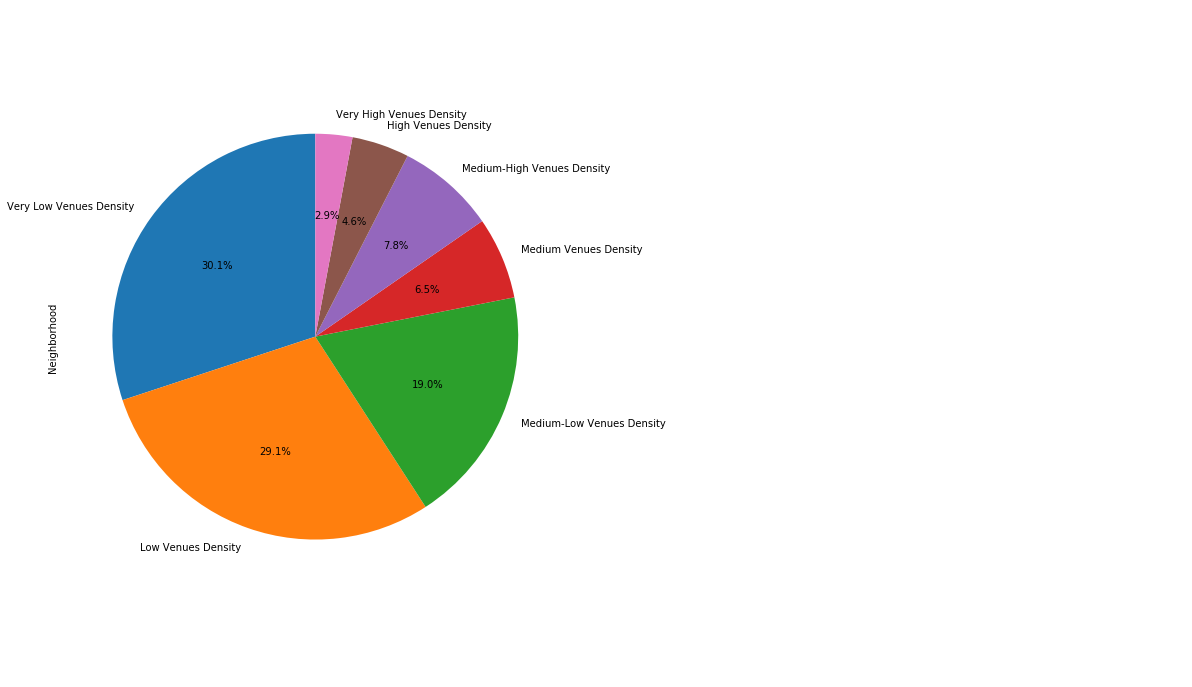

In [44]:
plt.figure(figsize=(20,12))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
df['Neighborhood'].plot(kind='pie', y = 'Clustter', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df['Cluster'], legend = False, fontsize=10)

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
plt.show()

In [46]:
#neighborhoods = pd.concat([neighborhoods[:257],neighborhoods[306:],neighborhoods[257:306]]) #move M5E to the last row
neighborhoods['Cluster'] = k_means.labels_
neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude,Distance,Cluster
0,Bronx,Wakefield,40.894705,-73.847201,565.0,4
1,Bronx,Co-op City,40.874294,-73.829939,481.0,0
2,Bronx,Eastchester,40.887556,-73.827806,742.0,0
3,Bronx,Fieldston,40.895437,-73.905643,388.0,0
4,Bronx,Riverdale,40.890834,-73.912585,388.0,3
5,Bronx,Kingsbridge,40.881687,-73.902818,436.0,3
6,Manhattan,Marble Hill,40.876551,-73.910660,384.0,6
7,Bronx,Woodlawn,40.898273,-73.867315,868.0,3
8,Bronx,Norwood,40.877224,-73.879391,468.0,0
9,Bronx,Williamsbridge,40.881039,-73.857446,439.0,4


In [47]:
# create map
map_clusters = folium.Map(location=[40.7127281, -74.0060152], zoom_start=11)

# set color scheme for the clusters
rainbow = ['magenta','gray','blue','green','cyan','yellow','red']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood'], neighborhoods['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=None,
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [48]:
result = neighborhoods.dtypes
print(result)

Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
Distance        float64
Cluster           int32
dtype: object


In [51]:
# create map
map2_clusters = folium.Map(location=[40.7127281, -74.0060152], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood'], neighborhoods['Cluster']):
    if cluster == 6:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=10,
            popup=label,
            color=None,
            fill=True,
            fill_color='red',
            fill_opacity=0.7).add_to(map2_clusters)

map2_clusters

In [52]:
for lat, lon, poi, cluster in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood'], neighborhoods['Cluster']):
    if cluster == 6:
        print(poi)

Marble Hill
Pelham Parkway
Upper East Side
Soho
Gramercy
Maspeth
Woodhaven
South Ozone Park
Douglaston
Fresh Meadows
Jamaica Center
Hillcrest
New Springville
Sunnyside
Rossville
Claremont Village
Broadway Junction
Egbertville
Bayswater
